In [39]:
import asyncio
import json
from typing import List
from datetime import datetime, timedelta

from grpclib.client import Channel
from cortexadmin_pb import CortexAdminStub, SeriesRequest, QueryRangeRequest, QueryRequest, MatcherRequest
from betterproto.lib.google.protobuf import Empty

default_query_interval = "1m"

async def get_all_users(service: CortexAdminStub) -> List[str]:
  response = await service.all_user_stats(Empty())
  return [r.user_id for r in response.items]

async def list_all_metric(service: CortexAdminStub, cluster_id: str) -> List[str]:
  response = await service.extract_raw_series(MatcherRequest(tenant=cluster_id, match_expr=".+"))
  res = (json.loads(response.data.decode())["data"])
  s = set()
  for r in res["result"]:
    s.add(r["metric"]["__name__"])
  return list(s)

async def metric_query(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni"):
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{default_query_interval}])) by (pod)'
  response = await service.query(QueryRequest(tenants=[cluster_id], query=query))
  response = json.loads(response.data.decode())["data"]
  return response

async def metric_queryrange(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni", end_time : datetime = None, time_delta : timedelta= timedelta(minutes=60), step_minute : int = 1):
  query_interval = f"{step_minute}m"
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{query_interval}])) by (pod)'
  if end_time is None:
    end_time = datetime.now()
  start_time = end_time - time_delta
  response = await service.query_range(QueryRangeRequest(tenants=[cluster_id], query=query, start=start_time, end=end_time, step=timedelta(minutes=step_minute)))
  response = json.loads(response.data.decode())["data"]
  return response

In [23]:
channel = Channel(host="localhost", port=11090) # url of opni-internal. can port-forward to localhost:11090
service = CortexAdminStub(channel)

Unclosed connection: Channel('localhost', 11090, ..., path=None)


In [24]:
user_id = (await get_all_users(service))[0]
user_id

'6165ba24-e496-491d-86f2-6eb083f24f0b'

In [25]:
metrics = await list_all_metric(service, user_id)

CancelledError: 

In [43]:
m_name = "container_cpu_usage_seconds_total"
q1 = await metric_queryrange(service, user_id, m_name, time_delta=timedelta(minutes=120),step_minute=2)
q1

{'resultType': 'matrix',
 'result': [{'metric': {'pod': 'cortex-all-0'},
   'values': [[1678493040, '0.654816092110307'],
    [1678493160, '0.628361025444359'],
    [1678493280, '0.5550903904944007'],
    [1678493400, '0.6913282244181778'],
    [1678493520, '0.5905992730201155'],
    [1678493640, '0.5878852117496915'],
    [1678493760, '0.6652888631729839'],
    [1678493880, '0.6325692003270157'],
    [1678494000, '0.6736020483586285'],
    [1678494120, '0.6462169442142416'],
    [1678494240, '0.648927499129571'],
    [1678494360, '0.5631020374038331'],
    [1678494480, '0.6167540981815234'],
    [1678494600, '0.5883005253732205'],
    [1678494720, '0.6157540491955651'],
    [1678494840, '0.6453923848038459'],
    [1678494960, '0.6546261170189829'],
    [1678495080, '0.6324528880643279'],
    [1678495200, '0.694028902135753'],
    [1678495320, '0.6031487082345914'],
    [1678495440, '0.6109780523681665'],
    [1678495560, '0.6298114602961'],
    [1678495680, '0.5890545563344658'],
    

In [44]:
import matplotlib.pyplot as plt
import numpy as np
def plt_plot(ts_data):
    # Plot the time series data
    plt.plot(ts_data)
    plt.title("Simulated Time Series Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()


opni-agent-0
[0.08123300110857287, 0.07678651102346357, 0.07670812409629688, 0.07938640354893288, 0.0750931229706707, 0.0909672933331889, 0.08962023476299272, 0.09093592590660701, 0.09378423384787263, 0.09154215380851999, 0.08632459342974327, 0.09675211485494772, 0.09575333437636531, 0.0949901051080437, 0.0856931472773341, 0.08763673626846509, 0.0876750643056683, 0.09712146093630485, 0.09909598176223267, 0.09501481752893938, 0.09297746232190846, 0.06970283687368153, 0.07782808472535083, 0.08742120805378908, 0.07145207518734166, 0.09153000375344016, 0.085500887390357, 0.0736493785576226, 0.07436781565125355, 0.07047555422426709, 0.07208356408506113, 0.07373733496278358, 0.06984832019517487, 0.07280265755030207, 0.06729387503069129, 0.0701867640503397, 0.06947749570802908, 0.07012109567675043, 0.07060221076974704, 0.06866810977149082, 0.06917686045755694, 0.06945515829185404, 0.06984122428832315, 0.07651028475713145, 0.07219339359735119, 0.07175167008668351, 0.0733774498309282, 0.0748023

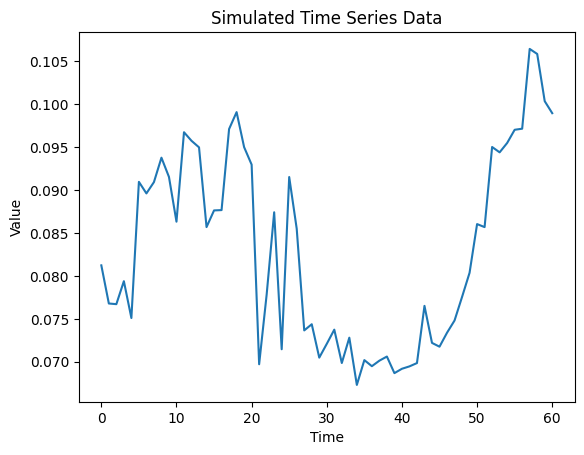

opni-gateway-799dfbf9cf-txnfh
[0.11718051440223912, 0.11368242741956602, 0.11199465441575676, 0.12430104621725917, 0.12107485242880645, 0.11632136566047258, 0.11794930145869395, 0.1218667433950925, 0.11401577844944763, 0.11745061156829967, 0.11711227262084845, 0.11512369351950816, 0.11648422596665903, 0.11580435573992026, 0.11793922533008748, 0.12020829532200507, 0.11708735405867722, 0.1094396048643469, 0.10687904510017529, 0.10700676273549325, 0.09563899261018709, 0.10982200586169688, 0.09050665705814781, 0.09774631294937304, 0.08602238621235123, 0.08575663847414353, 0.08361890577385747, 0.08459806084300081, 0.11567559432007057, 0.08424936539986984, 0.08565344704619388, 0.10642956643456108, 0.11907260093455468, 0.10253793422619087, 0.12248780336290903, 0.12591212363417958, 0.12195168114168385, 0.12105428287474806, 0.13632048743419217, 0.12461962840643279, 0.11226262859525893, 0.12142994289082282, 0.11924075770919712, 0.12227768887706697, 0.12237471141363138, 0.11763902510545955, 0.117

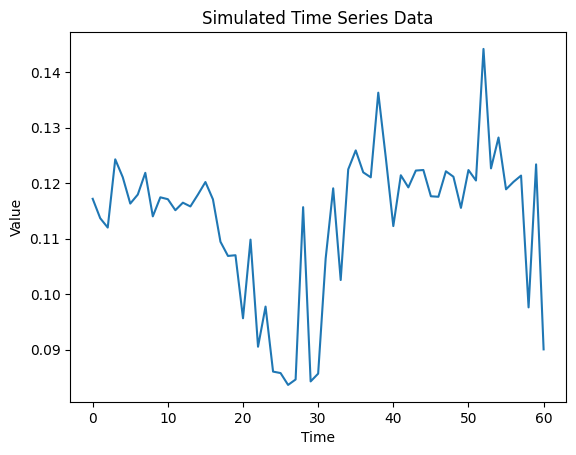

In [45]:
from scipy.stats import ks_2samp

threshold = 0.05
def anomaly_detection(metric_values: List[float]):
    cut = 45
    l1, l2 = metric_values[:cut], metric_values[cut:]
    ks_stat, p_value = ks_2samp(l1, l2)
    if p_value < threshold:
        return True, p_value
    else:
        return False, p_value

for r in q1["result"]:
    pod = r["metric"]["pod"]
    list0 = r["values"]
    values0 = [float(l[1]) for l in list0]
    is_anomaly, p_value = anomaly_detection(values0)
    if is_anomaly:
        print(pod)
        print(values0)
        plt_plot(np.array(values0))